In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.5.1 True
12.4
NVIDIA A40


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
def ou_process_1d(theta=1, mu=0, sigma=1, X0=0, n_steps=10000, n_eval=200, h=1e-5):
    """
    Simulates the Ornstein-Uhlenbeck process.
    
    Parameters:
    - theta: rate of mean reversion
    - mu: long-term mean of the process
    - sigma: volatility
    - X0: initial value
    - n_steps: number of steps in each evaluation
    - n_eval: number of evaluations
    - h: Integration step size
    
    Returns:
    - A numpy array containing the simulated values at each evaluation
    """
    X_eval = np.zeros(n_eval)
    X = X0
    
    for i in range(n_eval):
        for _ in range(n_steps):
            dW = np.sqrt(h) * np.random.randn()
            X = X + theta * (mu - X) * h + sigma * dW
        X_eval[i] = X
    
    return X_eval

## Setup the parameters
theta = 1
mu = 0
sigma = 0.1

In [4]:
# Generate m initial points from the domain space [-2, 2]
m = 10
n_eval = 200
n_steps = 1000
h = 1e-4
lag_time = n_steps * h
print("lag time: ", lag_time)
X0_values = np.linspace(-2, 2, m)

# Initialize the data_matrix
data_matrix = np.zeros((m, n_eval+1, 1))

# Simulate trajectories for each initial point and store them in the data_matrix
for i, X0 in tqdm(enumerate(X0_values), total=m, desc="Simulating trajectories"):
    X_eval = np.concatenate(([X0], ou_process_1d(X0=X0, n_steps=n_steps, n_eval=n_eval, h=h)))
    data_matrix[i, :, 0] = X_eval

# Print the shape of data_matrix
print("Shape of data_matrix:", data_matrix.shape)

# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

lag time:  0.1


Simulating trajectories: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

Shape of data_matrix: (10, 201, 1)
Shape of data_X: (10, 200, 1)
Shape of data_Y: (10, 200, 1)
Shape of X: (2000, 1)
Shape of Y: (2000, 1)
(1400, 1)


In [5]:
checkpoint_file= 'ou1d_example_ckpt002.torch'

from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch

basis_function = KoopmanNNTorch(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch', a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32, delta_t= lag_time)

data_x_train_tensor = torch.DoubleTensor(data_x_train).to (device)#, requieres_grad= True)#, dtype=tf.float64)
data_y_train_tensor = torch.DoubleTensor(data_y_train).to (device)#, requires_grad= True)#, dtype=tf.float64)

In [6]:
solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

Epoch: 1 	Training Loss: 0.702413 val loss: 0.778022
saving, val loss enhanced: 0.7780221497479287 10000
Epoch: 2 	Training Loss: 0.690798 val loss: 0.763897
saving, val loss enhanced: 0.7638971207764609 0.7780221497479287
Epoch: 3 	Training Loss: 0.680326 val loss: 0.751941
saving, val loss enhanced: 0.751941357742099 0.7638971207764609
Epoch: 4 	Training Loss: 0.670809 val loss: 0.743458
saving, val loss enhanced: 0.7434584548950707 0.751941357742099
Epoch: 5 	Training Loss: 0.661255 val loss: 0.732565
saving, val loss enhanced: 0.7325653605187937 0.7434584548950707
Epoch: 6 	Training Loss: 0.652701 val loss: 0.727984
saving, val loss enhanced: 0.727983744435811 0.7325653605187937
Epoch: 7 	Training Loss: 0.643421 val loss: 0.723017
saving, val loss enhanced: 0.7230171489957822 0.727983744435811
Epoch: 8 	Training Loss: 0.637440 val loss: 0.711467
saving, val loss enhanced: 0.7114672092606596 0.7230171489957822
Epoch: 9 	Training Loss: 0.628125 val loss: 0.702522
saving, val loss enh

Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7986.27iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_ou.jbl
Outer Epoch 1/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7875.98iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 17629.451843 val loss: 17082.641058
saving, val loss enhanced: 17082.641057734185 1000000000000000.0
Epoch: 2 	Training Loss: 17544.874767 val loss: 17001.051653
saving, val loss enhanced: 17001.05165301618 17082.641057734185
Epoch: 3 	Training Loss: 17461.394215 val loss: 16919.812903
saving, val loss enhanced: 16919.812902573733 17001.05165301618


/workspace/solver_edmd_torch_gpu_sde.py:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch: 4 	Training Loss: 17378.341029 val loss: 16838.944648
saving, val loss enhanced: 16838.944647768356 16919.812902573733
Epoch 1 time: 8.67 seconds
Outer Epoch 2/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8755.01iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 17277.628702 val loss: 16744.318256
saving, val loss enhanced: 16744.31825604854 16838.944647768356
Epoch: 2 	Training Loss: 17197.454347 val loss: 16666.366925
saving, val loss enhanced: 16666.366925173705 16744.31825604854
Epoch: 3 	Training Loss: 17117.844496 val loss: 16588.868327
saving, val loss enhanced: 16588.868326804 16666.366925173705
Epoch: 4 	Training Loss: 17038.649184 val loss: 16511.727856
saving, val loss enhanced: 16511.72785555909 16588.868326804
Epoch 2 time: 6.91 seconds
Outer Epoch 3/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8582.59iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 16896.556376 val loss: 16377.076342
saving, val loss enhanced: 16377.076342379534 16511.72785555909
Epoch: 2 	Training Loss: 16820.429759 val loss: 16303.101692
saving, val loss enhanced: 16303.101692146322 16377.076342379534
Epoch: 3 	Training Loss: 16744.890557 val loss: 16229.571501
saving, val loss enhanced: 16229.571500747712 16303.101692146322
Epoch: 4 	Training Loss: 16669.739144 val loss: 16156.355573
saving, val loss enhanced: 16156.35557262023 16229.571500747712
Epoch 3 time: 7.34 seconds
Outer Epoch 4/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9193.97iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 16542.892381 val loss: 16036.294000
saving, val loss enhanced: 16036.294000059537 16156.35557262023
Epoch: 2 	Training Loss: 16470.525097 val loss: 15965.962750
saving, val loss enhanced: 15965.962750391569 16036.294000059537
Epoch: 3 	Training Loss: 16398.692888 val loss: 15896.029144
saving, val loss enhanced: 15896.029143794298 15965.962750391569
Epoch: 4 	Training Loss: 16327.203071 val loss: 15826.367013
saving, val loss enhanced: 15826.367012731187 15896.029143794298
Epoch 4 time: 7.03 seconds
Outer Epoch 5/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8248.84iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 16235.450457 val loss: 15740.223115
saving, val loss enhanced: 15740.223114771474 15826.367012731187
Epoch: 2 	Training Loss: 16166.310664 val loss: 15672.999697
saving, val loss enhanced: 15672.99969697318 15740.223114771474
Epoch: 3 	Training Loss: 16097.634272 val loss: 15606.121223
saving, val loss enhanced: 15606.12122267513 15672.99969697318
Epoch: 4 	Training Loss: 16029.255280 val loss: 15539.478687
saving, val loss enhanced: 15539.478687334868 15606.12122267513
Epoch 5 time: 7.27 seconds
Outer Epoch 6/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 10488.25iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 16113.586255 val loss: 15623.894382
Epoch: 2 	Training Loss: 16046.478615 val loss: 15558.543802
Epoch: 3 	Training Loss: 15979.664232 val loss: 15493.428346
saving, val loss enhanced: 15493.428346032679 15539.478687334868
Epoch: 4 	Training Loss: 15913.062943 val loss: 15428.495491
saving, val loss enhanced: 15428.495490607886 15493.428346032679
Epoch 6 time: 6.35 seconds


/workspace/solver_edmd_torch_gpu_sde.py:684: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


In [7]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Koopman_matrix_K = solver.K
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict,
    'K': Koopman_matrix_K
    }

[-4.78969312e-05+0.j -8.98281594e-01+0.j -2.00978946e+00+0.j
 -3.04973348e+00+0.j]


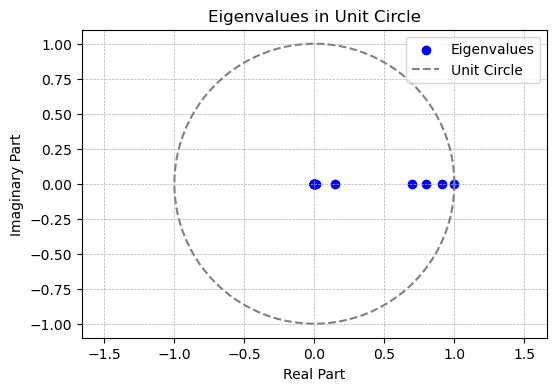

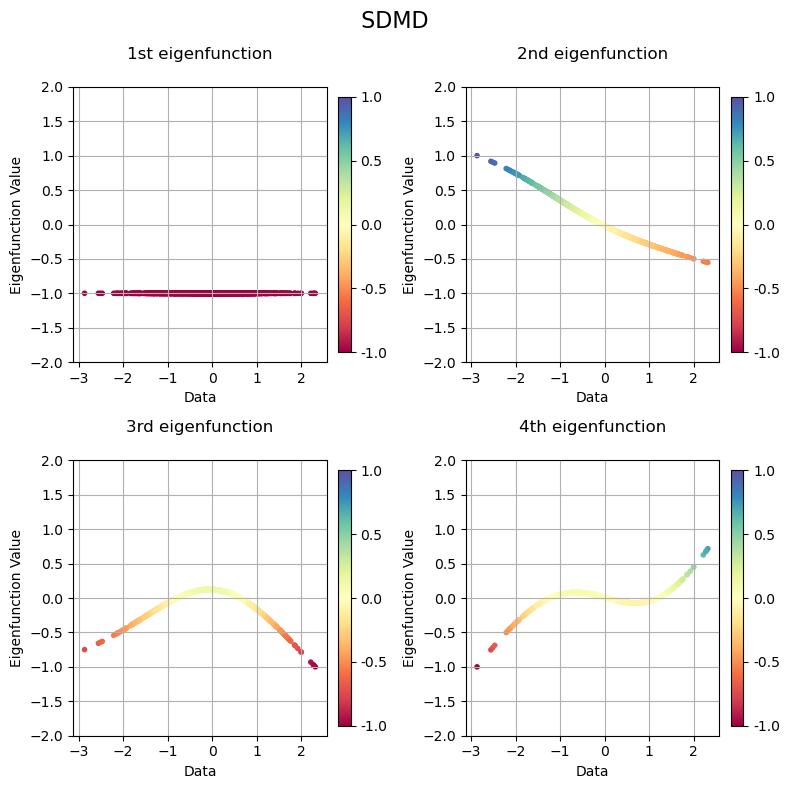

In [8]:
# Take ln values of the eigenvalues and divide by 0.1
# ln_evalues = np.log(evalues[:4]) / lag_time
ln_evalues = (evalues[:4]-1) / lag_time

print(ln_evalues)

## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' SDMD ', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
basis_function_g = KoopmanNNTorch_g(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver_g = KoopmanSolverTorch_g(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch',  a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32)

In [10]:
solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=32,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8,   
    )

Precomputed SDE coefficients loaded from: a_b_example_ou.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8924.63iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Outer Epoch 1/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9127.32iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9034.65iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9380.00iteration/s]


Epoch: 1 	Training Loss: 0.614416 val loss: 0.586712
saving, val loss enhanced: 0.5867121608114403 1000000000000000.0
Epoch: 2 	Training Loss: 0.600825 val loss: 0.573858
saving, val loss enhanced: 0.5738575869593269 0.5867121608114403
Epoch: 3 	Training Loss: 0.587829 val loss: 0.561426
saving, val loss enhanced: 0.561425728865969 0.5738575869593269
Epoch: 4 	Training Loss: 0.575206 val loss: 0.549319
saving, val loss enhanced: 0.5493191064478528 0.561425728865969


/workspace/solver_gedmd_torch_gpu.py:309: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch 1 time: 17.13 seconds
Outer Epoch 2/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9694.21iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9094.08iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9625.17iteration/s]


Epoch: 1 	Training Loss: 0.536428 val loss: 0.513355
saving, val loss enhanced: 0.513354612339236 0.5493191064478528
Epoch: 2 	Training Loss: 0.527596 val loss: 0.504878
saving, val loss enhanced: 0.5048779912481134 0.513354612339236
Epoch: 3 	Training Loss: 0.518881 val loss: 0.496469
saving, val loss enhanced: 0.4964688047748289 0.5048779912481134
Epoch: 4 	Training Loss: 0.510243 val loss: 0.488141
saving, val loss enhanced: 0.48814075438842797 0.4964688047748289
Epoch 2 time: 16.35 seconds
Outer Epoch 3/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9747.78iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8589.33iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8705.85iteration/s]


Epoch: 1 	Training Loss: 0.505827 val loss: 0.484912
saving, val loss enhanced: 0.4849115779249647 0.48814075438842797
Epoch: 2 	Training Loss: 0.499025 val loss: 0.478368
saving, val loss enhanced: 0.47836775836615186 0.4849115779249647
Epoch: 3 	Training Loss: 0.492274 val loss: 0.471844
saving, val loss enhanced: 0.4718441462560908 0.47836775836615186
Epoch: 4 	Training Loss: 0.485548 val loss: 0.465346
saving, val loss enhanced: 0.4653462221090497 0.4718441462560908
Epoch 3 time: 18.40 seconds
Outer Epoch 4/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9378.44iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9044.12iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8668.14iteration/s]


Epoch: 1 	Training Loss: 0.488342 val loss: 0.468769
Epoch: 2 	Training Loss: 0.482699 val loss: 0.463344
saving, val loss enhanced: 0.46334449467542316 0.4653462221090497
Epoch: 3 	Training Loss: 0.477106 val loss: 0.457948
saving, val loss enhanced: 0.4579479277867979 0.46334449467542316
Epoch: 4 	Training Loss: 0.471541 val loss: 0.452578
saving, val loss enhanced: 0.4525779872158713 0.4579479277867979
Epoch 4 time: 19.46 seconds
Outer Epoch 5/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9275.37iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9534.00iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9514.36iteration/s]


Epoch: 1 	Training Loss: 0.482956 val loss: 0.464281
Epoch: 2 	Training Loss: 0.478127 val loss: 0.459637
Epoch: 3 	Training Loss: 0.473338 val loss: 0.455016
Epoch: 4 	Training Loss: 0.468570 val loss: 0.450414
saving, val loss enhanced: 0.45041414866131746 0.4525779872158713
Epoch 5 time: 18.87 seconds
Outer Epoch 6/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9424.45iteration/s] 


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 10735.14iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9729.33iteration/s] 


Epoch: 1 	Training Loss: 0.488520 val loss: 0.470353
Epoch: 2 	Training Loss: 0.484179 val loss: 0.466176
Epoch: 3 	Training Loss: 0.479878 val loss: 0.462029


/workspace/solver_gedmd_torch_gpu.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


Epoch: 4 	Training Loss: 0.475605 val loss: 0.457906
Epoch 6 time: 17.56 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 10053.50iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0


In [11]:
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict
    }

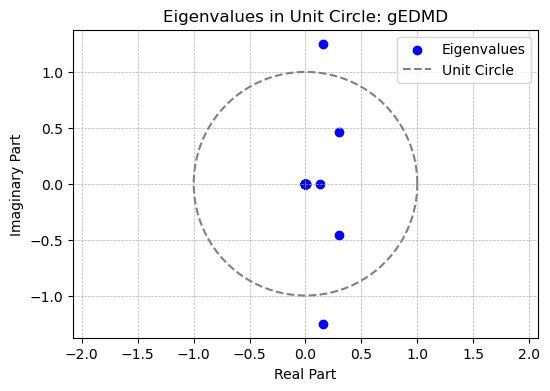

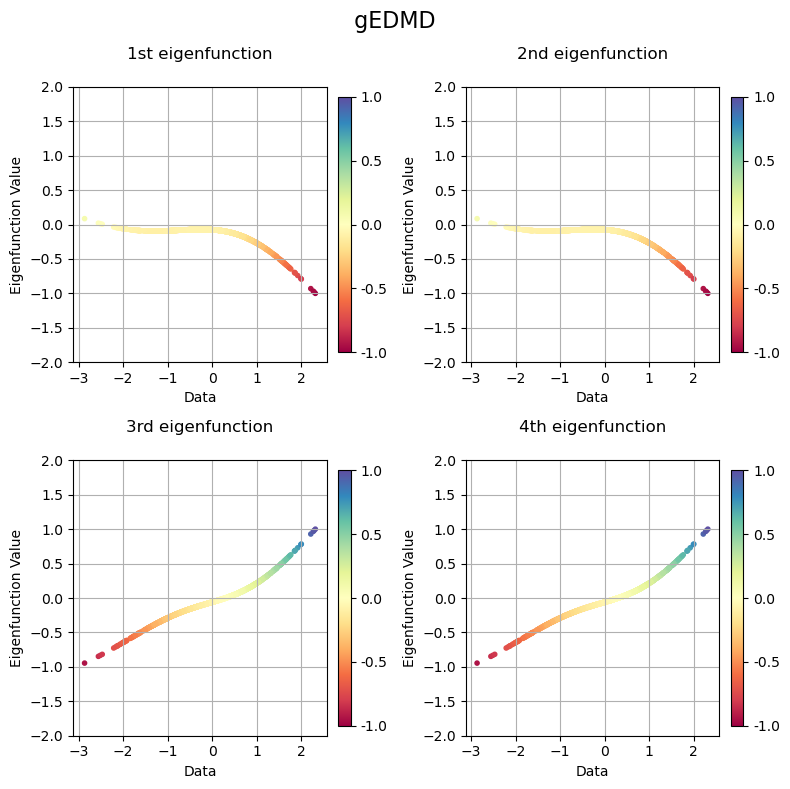

In [12]:
## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()